# Setup

In [ ]:
%pip install tensorflow tensorboard

In [61]:
%pip install faiss-gpu

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 85.5 MB 6.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

# Dataloader & Dataset Visualization

In [4]:
import torch
import matplotlib.pyplot as plt

from copy import deepcopy
from torchvision import transforms
from torch.utils.data import DataLoader
from dataset import MVTecAT, Repeat, CutPasteMVTecAD
from cutpaste import CutPasteUnion, CutPaste3Way

In [5]:
class Args:
    def __init__(self) -> None:
        self.min_scale = 1
        self.size = 256
        self.cutpate_type = CutPasteUnion
        self.batch_size = 64
        self.workers = 8
        self.root_dir = '/sinergia/shabanza/datasets/mvtec'
        self.head_layer = 2
        self.data_type = 'zipper'
        self.learninig_rate = 0.03
        self.epochs = 256
        self.pretrained = True
        self.freeze_net = 20
        self.optim = 'sgd'


args = Args()

## Train DataLoader

Returns good + cutpaste Images ([0] is original, [1] is cutpasted)

In [6]:
from copy import deepcopy

train_transform = transforms.Compose([])
train_transform.transforms.append(transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1))
train_transform.transforms.append(transforms.Resize((args.size, args.size)))

after_cutpaste_transform = transforms.Compose([])
after_cutpaste_transform.transforms.append(transforms.ToTensor())
after_cutpaste_transform.transforms.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225]))

train_cutpaste_transform = deepcopy(train_transform)
train_cutpaste_transform.transforms.append(args.cutpate_type(transform=after_cutpaste_transform))
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225]))

In [7]:
test_transform = transforms.Compose([])
test_transform.transforms.append(transforms.Resize((args.size, args.size)))
test_transform.transforms.append(transforms.ToTensor())
test_transform.transforms.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225]))

In [17]:
size = int(args.size * (1/args.min_scale))

train_ds_normal = MVTecAT(args.root_dir, args.data_type, transform=train_transform, size=size, mode="train")
train_ds_anomal = CutPasteMVTecAD(args.root_dir, args.data_type, transform=train_cutpaste_transform, size=size, mode="train")
train_ds = torch.utils.data.ConcatDataset([train_ds_normal, train_ds_anomal])

train_dataloader = DataLoader(Repeat(train_ds, 3000), batch_size=args.batch_size, drop_last=True,
                        shuffle=True, num_workers=args.workers,
                        persistent_workers=True, pin_memory=True, prefetch_factor=5)

train_dataloader_normal = DataLoader(Repeat(train_ds_normal, 3000), batch_size=args.batch_size, drop_last=True,
                        shuffle=True, num_workers=args.workers,
                        persistent_workers=True, pin_memory=True, prefetch_factor=5)

loading images
loaded 240 images
loading images
loaded 240 images


## Test DataLoader

Returns images + labels (good / bad)

In [9]:
test_ds = MVTecAT(args.root_dir, args.data_type, args.size, transform=test_transform, mode="test")
test_dataloader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False, num_workers=0)

In [10]:
def visualize(sample_images):
    # Convert the tensor to numpy array
    sample_images_np = sample_images.numpy()

    # Reshape the tensor to [num_samples, 256, 256, 3] for visualization
    sample_images_np = sample_images_np.transpose(0, 2, 3, 1)

    # Plot the sample images
    fig, axes = plt.subplots(1, sample_images_np.shape[0], figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(sample_images_np[i])
        ax.axis('off')

    plt.show()

In [11]:
num_samples = 5
sample_indices = torch.randperm(args.batch_size)[:num_samples]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


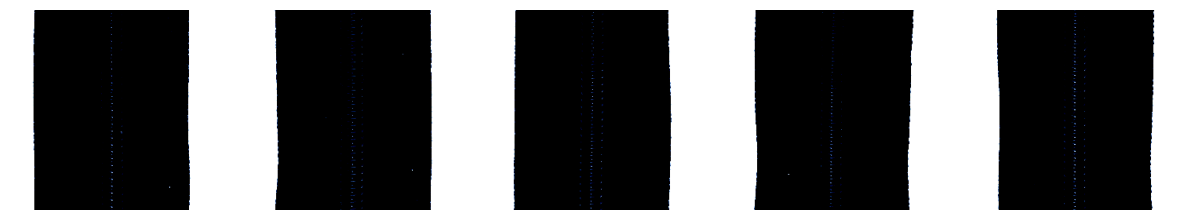

In [18]:
# visualize normal

batch = next(iter(train_dataloader_normal))[0]
sample_images = batch[sample_indices]
visualize(sample_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


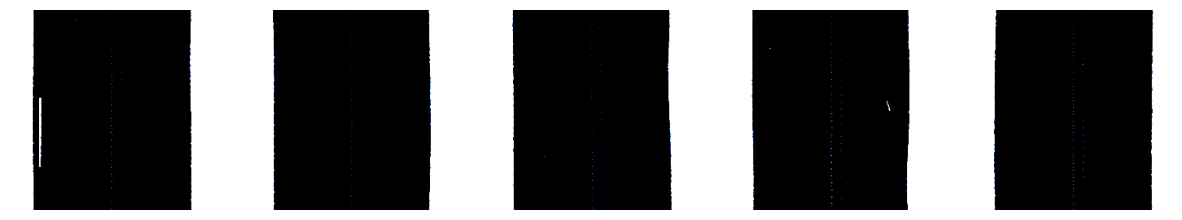

In [19]:
# visualize normal + cutpaste

batch = next(iter(train_dataloader))[0]
sample_images = batch[sample_indices]
visualize(sample_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


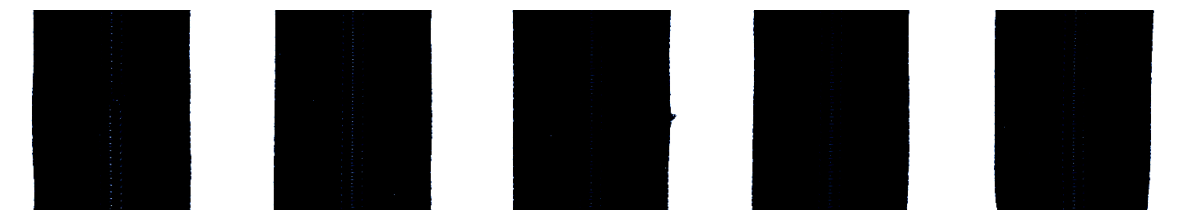

In [14]:
# visualize test

batch = next(iter(test_dataloader))[0]
sample_images = batch[sample_indices]
visualize(sample_images)

# Train

In [39]:
import sys
import numpy as np
import torch.optim as optim
from sklearn import metrics
import time
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from model import ProjectionNet

In [40]:
def train(model, loader, loss_fn, optimizer, device):
    """ training one epoch and calculate loss and metrics """
    # Training model
    model.train()
    losses = 0.0
    steps = len(loader)
    correct = 0.0
    total = 0.0
    which_class = 1
    preds = []
    targs = []
    softmax = torch.nn.Softmax(dim=1)
    for i, (inputs, targets) in enumerate(loader):
        # Place to gpu
        inputs = inputs.to(device)
        targets = targets.to(torch.int64).to(device)

        # Forward pass
        outputs, _ = model(inputs)
        
        # Calculate loss
        loss = loss_fn(outputs, targets.long())
        losses += loss

        # Backpropagation and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # Calculate metrics
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

        probs = softmax(outputs).squeeze()
        preds.append(probs[:, which_class].detach().cpu())
        targs.append((targets.cpu()==which_class)*1.0)

        # report
        sys.stdout.flush()
        sys.stdout.write('\r Step: [%2d/%2d], loss: %.4f - acc: %.4f'
                          % (i, steps, targets.size(0)*losses.item()/total, 100.0*correct/total))
    sys.stdout.write ('\r')

    preds = torch.cat(preds).numpy()
    targs = torch.cat(targs).numpy()
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds)
    train_auc = metrics.auc(fpr, tpr)

    return train_auc, losses.item()/total, 100.0*correct/total


In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


head_layers = [512]*args.head_layer+[128]
num_classes = 2 if args.cutpate_type is not CutPaste3Way else 3
model = ProjectionNet(pretrained=args.pretrained, head_layers=head_layers, num_classes=num_classes)
model.to(device)

if args.freeze_net > 0 and args.pretrained:
    model.freeze_resnet()

In [42]:
weight_decay = 0.00003
momentum = 0.9


loss_fn = torch.nn.CrossEntropyLoss()
if args.optim == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=args.learninig_rate, momentum=momentum,  weight_decay=weight_decay)
    scheduler = CosineAnnealingWarmRestarts(optimizer, args.epochs)
    #scheduler = None
elif args.optim == "adam":
    optimizer = optim.Adam(model.parameters(), lr=args.learninig_rate, weight_decay=weight_decay)
    scheduler = None

# Evaluate

In [43]:
import faiss
from sklearn.metrics import roc_auc_score

def knn_score(train_set, test_set, n_neighbours=2):
    """
    Calculates the KNN distance
    """
    index = faiss.IndexFlatL2(train_set.shape[1])
    index.add(train_set)
    D, _ = index.search(test_set, n_neighbours)
    return np.sum(D, axis=1)

def knn_evaluate(model, test_loader, train_loader_normal, loss_fn, device):
    """ Evaluate trained weights using calculate loss and metrics """
    model.eval ()
    softmax = torch.nn.Softmax(dim=1)
    test_feature_space = []
    test_labels = []
    train_feature_space = []
    with torch.no_grad ():
        for inputs, targets in test_loader:
            '''
            activation = {}
            def get_activation(name):
                def hook(model, input, output):
                    activation[name] = output.detach()
                return hook
            m.model.heads.head.register_forward_hook(get_activation('feature'))
            '''
            inputs = inputs.to(device)
            targets = targets.to(torch.int64).to(device)
            outputs, features = model (inputs)
            test_feature_space.append(features)
            test_labels.append(targets.detach().cpu())

        for inputs, targets in train_loader_normal:
            '''
            activation = {}
            def get_activation(name):
                def hook(model, input, output):
                    activation[name] = output.detach()
                return hook
            m.model.heads.head.register_forward_hook(get_activation('feature'))
            '''
            inputs = inputs.to(device)
            targets = targets.to(torch.int64).to(device)
            outputs, features = model (inputs)
            train_feature_space.append(features)

    test_labels = torch.cat(test_labels, dim=0).cpu().numpy()
    test_feature_space = torch.cat(test_feature_space, dim=0).contiguous().cpu().numpy()
    train_feature_space = torch.cat(train_feature_space, dim=0).contiguous().cpu().numpy()

    distances = knn_score(train_feature_space, test_feature_space)
    auc = roc_auc_score(test_labels, distances)
    return auc, distances, test_labels

In [44]:
def evaluate(model, loader, loss_fn, device):
    """ Evaluate trained weights using calculate loss and metrics """
    model.eval ()
    losses = 0.0
    steps = len(loader)
    correct = 0.0
    total = 0.0
    which_class = 1
    preds = []
    targs = []
    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad ():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(torch.int64).to(device)

            outputs, _ = model(inputs)
            loss = loss_fn(outputs, targets)
            losses += loss

            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

            probs = softmax(outputs).squeeze()
            preds.append(probs[:, which_class].detach().cpu())
            targs.append((targets.cpu()==which_class)*1.0)

    preds = torch.cat(preds).numpy()
    targs = torch.cat(targs).numpy()
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds)
    eval_auc = metrics.auc(fpr, tpr)

    return eval_auc, losses.item()/total, 100.0*correct/total, preds, targs

# Run

In [45]:
def fit(model, train_dl, valid_dl, train_loader_normal, loss_fn, optimizer, num_epochs, device, scheduler=None):
    """ fiting model to dataloaders, saving best weights and showing results """
    losses, val_losses, accs, val_accs, auces, val_auces, val_auces_knn, val_auces_msp_knn = [], [], [], [], [], [], [], []
    best_auc = 0.0

    since = time.time ()
    for epoch in range (num_epochs):
        # if epoch == args.freeze_net:
        #     model.unfreeze()
        train_auc, loss, acc = train(model, train_dl, loss_fn, optimizer, device)
        val_auc, val_loss, val_acc, preds, targs = evaluate(model, valid_dl, loss_fn, device)
        val_auc_knn, distances, _ = knn_evaluate(model, valid_dl, train_loader_normal, loss_fn, device)

        out = preds + (distances / np.linalg.norm(distances))
        fpr, tpr, thresholds = metrics.roc_curve(targs, out)
        msp_knn_auc = metrics.auc(fpr, tpr)

        losses.append(loss)
        accs.append(acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        auces.append(train_auc)
        val_auces.append(val_auc)
        val_auces_knn.append(val_auc_knn)
        val_auces_msp_knn.append(msp_knn_auc)

        # learning rate scheduler
        if scheduler is not None:
            scheduler.step(val_auc)

        # save weights if improved
        if val_auc > best_auc:
            checkpoint = {'state_dict': model.state_dict (), 'optimizer': optimizer.state_dict ()}
            # save_checkpoint(checkpoint, checkpoint_path)
            best_auc = val_auc

        print ('Epoch [{}/{}], loss: {:.4f} - auc: {:.4f} |\n val_loss: {:.4f} - val_acc: {:.4f} - val_auc_msp: {:.4f} - val_auc_knn: {:.4f} - val_auc_knn_msp: {:.4f}'
               .format (epoch + 1, num_epochs, loss, train_auc, val_loss, val_acc, val_auc, val_auc_knn, msp_knn_auc))

    period = time.time () - since
    print ('Training complete in {:.0f}m {:.0f}s'.format (period // 60, period % 60))

    return dict(loss=losses, val_loss=val_losses, acc=accs, val_acc=val_accs, auces=auces, val_auces=val_auces, val_auces_knn=val_auces_knn, val_auces_msp_knn=val_auces_msp_knn)


In [46]:
def plot_metrics(val_auc_knn, val_auc, val_auc_knn_msp):
    """ ploting each of metric in one line """

    # fig, ax = plt.subplots (1, 1, figsize = (20, 5))
    plt.plot(range(len(val_auc_knn)), val_auc_knn, 'b-', label = 'Val_AUC_KNN')
    plt.plot(range(len(val_auc)), val_auc, 'r-', label = 'Val_AUC_MSP')
    plt.plot(range(len(val_auc_knn_msp)), val_auc_knn_msp, 'g-', label = 'Val_AUC_KNN_MSP')
    plt.title('AUC')
    plt.legend()
    plt.show()

In [47]:
history = fit(
    model=model, 
    train_dl=train_dataloader, 
    valid_dl=test_dataloader, 
    train_loader_normal=train_dataloader_normal, 
    loss_fn=loss_fn, optimizer=optimizer, 
    num_epochs=args.epochs, device=device, 
    scheduler=scheduler
)
plot_metrics(history["val_auces_knn"], history["val_auces"], history["val_auces_msp_knn"])

Epoch [1/256], loss: 0.0083 - auc: 0.7753 |
 val_loss: 0.0072 - val_acc: 79.4702 - val_auc_msp: 0.8451 - val_auc_knn: 0.8761 - val_auc_knn_msp: 0.8506
Epoch [2/256], loss: 0.0070 - auc: 0.8298 |
 val_loss: 0.0059 - val_acc: 84.7682 - val_auc_msp: 0.9199 - val_auc_knn: 0.8553 - val_auc_knn_msp: 0.9252
Epoch [3/256], loss: 0.0071 - auc: 0.8237 |
 val_loss: 0.0066 - val_acc: 85.4305 - val_auc_msp: 0.8989 - val_auc_knn: 0.8658 - val_auc_knn_msp: 0.9049
Epoch [4/256], loss: 0.0068 - auc: 0.8303 |
 val_loss: 0.0065 - val_acc: 83.4437 - val_auc_msp: 0.9168 - val_auc_knn: 0.8590 - val_auc_knn_msp: 0.9212
Epoch [5/256], loss: 0.0067 - auc: 0.8358 |
 val_loss: 0.0083 - val_acc: 76.8212 - val_auc_msp: 0.8808 - val_auc_knn: 0.8637 - val_auc_knn_msp: 0.8931
Epoch [6/256], loss: 0.0067 - auc: 0.8287 |
 val_loss: 0.0068 - val_acc: 84.7682 - val_auc_msp: 0.9149 - val_auc_knn: 0.8592 - val_auc_knn_msp: 0.9215
Epoch [7/256], loss: 0.0064 - auc: 0.8512 |
 val_loss: 0.0074 - val_acc: 80.7947 - val_auc_msp